<a href="https://colab.research.google.com/github/cstorres1/SeriesT/blob/main/TPFinal_Darts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librería DARTS

La librería Darts es una herramienta en Python diseñada específicamente para el análisis y pronóstico de series temporales. Su propósito es proporcionar una API sencilla y flexible que permita a los usuarios aplicar diversos modelos de series temporales, incluyendo tanto modelos clásicos como métodos avanzados de Machine Learning.

#Características principales de Darts:

Modelos Soportados: Darts ofrece una amplia variedad de modelos, desde ARIMA y Exponential Smoothing hasta modelos basados en redes neuronales como LSTM y N-BEATS.

Preprocesamiento y Transformaciones: La librería facilita el manejo de datos de series temporales, permitiendo transformaciones como escalado, diferenciación, y el manejo de covariables (variables exógenas).

Compatibilidad con Modelos Multivariados: Aunque Darts inicialmente se centraba en series univariadas, también soporta análisis multivariado, permitiendo integrar y modelar múltiples series de tiempo simultáneamente.

Evaluación y Validación: Darts proporciona herramientas para backtesting y la evaluación del rendimiento de los modelos, permitiendo comparar diferentes enfoques y seleccionar el más adecuado para los datos específicos.

Facilidad de Uso: Darts está diseñado para ser fácil de usar, con una sintaxis intuitiva y bien documentada, lo que la convierte en una buena opción tanto para expertos como para principiantes en el análisis de series temporales.

In [2]:
import torch
print(torch.__version__)

2.3.1+cu121


In [3]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0

In [18]:
# Cargar librerias

import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import NBEATSModel, AutoARIMA, ExponentialSmoothing, Prophet, LightGBMModel, NaiveSeasonal
from darts.metrics import mape
from darts.utils.missing_values import fill_missing_values
from darts.dataprocessing.transformers import Scaler
from darts.utils.statistics import check_seasonality
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
import matplotlib.pyplot as plt




In [19]:

# Cargar los datos desde la URL
url = "https://raw.githubusercontent.com/cstorres1/SeriesT/main/COMIDAS.xlsx"
data = pd.read_excel(url)

# Procesar el DataFrame
data["Fecha"] = pd.to_datetime(data["Fecha"])
data.set_index('Fecha', inplace=True)


## Crear un objeto TimeSeries en Darts



In [20]:
# Seleccionar la columna que se desea pronosticar como serie temporal
series = TimeSeries.from_dataframe(data, value_cols='Comidas')

# Convertir las columnas categóricas a numéricas (por ejemplo, One-Hot Encoding)
data = pd.get_dummies(data, columns=['Dia', 'VienDir'])


# Definir las series temporales para las covariables (todas las demás columnas)
covariates = TimeSeries.from_dataframe(data, value_cols=data.columns.difference(['Comidas']))


## Escalar los datos usando el scaler de Darts

No siempre es necesario escalar los datos, especialmente si se utilizan modelos que no dependen tanto del escalado, como AutoARIMA, Prophet, o ExponentialSmoothing. Sin embargo, para modelos basados en redes neuronales o aquellos que usan técnicas de machine learning como NBEATSModel o LightGBMModel, el escalado de los datos puede mejorar significativamente el rendimiento.

¿Cuándo es importante escalar los datos?
Modelos de Deep Learning: Los modelos como NBEATSModel y otros modelos de redes neuronales funcionan mejor cuando los datos están escalados, ya que esto asegura que todas las características tengan un rango similar, mejorando la estabilidad y velocidad del entrenamiento.
Modelos Basados en Gradiente: Modelos como LightGBM que utilizan gradientes también pueden beneficiarse del escalado para converger más rápidamente.

Incluir el escalado en el proceso es una buena práctica, especialmente cuando se trabaja con modelos que dependen de técnicas de optimización basadas en gradientes. Esto asegurará que todos los modelos funcionen en condiciones óptimas.


In [26]:
# Escalar la serie principal y las covariables por separado
scaler_series = Scaler()
scaler_covariates = Scaler()

series_scaled = scaler_series.fit_transform(series)
covariates_scaled = scaler_covariates.fit_transform(covariates)



In [27]:
# Dividir la serie en entrenamiento y validación
train, val = series_scaled.split_before(0.75)
cov_train, cov_val = covariates_scaled.split_before(0.75)

In [28]:

# Identificación de la estacionalidad
for m in range(2, 370):
    seasonal, period = check_seasonality(train, m=m, max_lag=400, alpha=0.05)
    if seasonal:
        print("Estacionalidad identificada con orden:", period)
        k = period
        break

# Si no se identificó estacionalidad, usar un valor por defecto
if not seasonal:
    k = 30  # Un valor por defecto, puede ajustarse según los datos

Estacionalidad identificada con orden: 7


MAPE del modelo NaiveSeasonal:  707.8840968280513


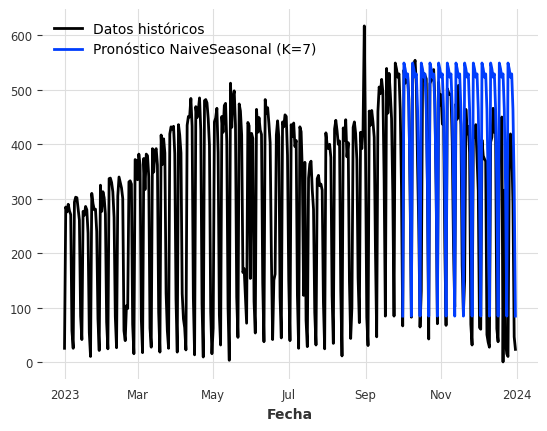

In [30]:

# Modelo NaiveSeasonal sin covariables
naive_model = NaiveSeasonal(K=k)
naive_model.fit(train)
naive_forecast = naive_model.predict(len(val))

# Revertir el escalado para la serie principal
naive_forecast_unscaled = scaler_series.inverse_transform(naive_forecast)
val_unscaled = scaler_series.inverse_transform(val)

print("MAPE del modelo NaiveSeasonal: ", mape(val_unscaled, naive_forecast_unscaled))
series.plot(label="Datos históricos")
naive_forecast_unscaled.plot(label="Pronóstico NaiveSeasonal (K=" + str(k) + ")")
plt.legend()
plt.show()


In [ ]:

# Crear y entrenar un modelo NBEATS
model = NBEATSModel(input_chunk_length=30, output_chunk_length=10)
model.fit(train)

# Realizar predicciones
forecast = model.predict(len(val))


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.5 K     Non-trainable params
6.2 M     Total params
24.975    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:

# Invertir el escalado para obtener los valores originales
forecast_unscaled = scaler.inverse_transform(forecast)
val_unscaled = scaler.inverse_transform(val)

# Evaluar el modelo
error = mape(val_unscaled, forecast_unscaled)
print(f"MAPE: {error}")

# Graficar los resultados
series.plot(label="Datos históricos")
forecast_unscaled.plot(label="Pronóstico")
plt.legend()
plt.show()

In [ ]:

# Función para evaluar diferentes modelos con covariables
def model_check(model, model_name):
    model.fit(train, past_covariates=cov_train)
    forecast = model.predict(len(val), past_covariates=cov_val)
    forecast_unscaled = scaler_series.inverse_transform(forecast)
    print(f"{model_name}, MAPE: ", mape(val_unscaled, forecast_unscaled))
    forecast_unscaled.plot(label=f"Pronóstico {model_name}")
    return model

In [ ]:

# Evaluación de otros modelos que soportan covariables
exp_smoothing = model_check(ExponentialSmoothing(), "Exponential Smoothing")
auto_arima = model_check(AutoARIMA(), "AutoARIMA")
nbeats_model = model_check(NBEATSModel(input_chunk_length=k, output_chunk_length=len(val)), "NBEATSModel")
prophet_model = model_check(Prophet(), "Prophet")
lightgbm_model = model_check(LightGBMModel(lags=k, lags_past_covariates=[-k]), "LightGBM")

In [ ]:
# Graficar los resultados finales
series.plot(label="Datos históricos")
plt.legend()
plt.show()